In [5]:
from utils import *
%matplotlib inline 

import tensorflow as tf
import time
from time import gmtime, strftime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T


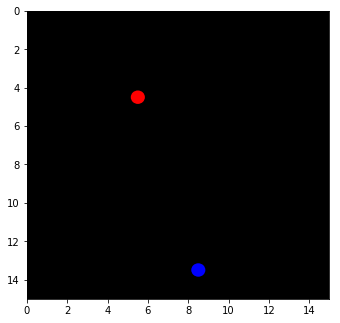

In [6]:
#========================
# Environment Parameters
#======================== 
height = 15
width = 15

mazetype = 'none'
#obstacle density
obs_rho = 0

#place cells
place_cells = 700
#place cell full width half max (must be <1)
fwhm = .2

#make environment
maze = gridworld([height, width],rho=obs_rho,num_pc=place_cells, pc_fwhm=fwhm, maze_type=mazetype)

make_env_plots(maze,1,0,0)

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(448, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1)
                         
                         
                         
resize = T.Compose([T.ToPILImage(),
                    T.Scale(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

# This is based on the code from gym.
screen_width = 600


def get_cart_location():
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART


def get_screen():
    screen = env.render(mode='rgb_array').transpose(
        (2, 0, 1))  # transpose into torch order (CHW)
    # Strip off the top and bottom of the screen
    screen = screen[:, 160:320]
    view_width = 320
    cart_location = get_cart_location()
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescare, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).type(Tensor)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [ ]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

model = DQN()

if use_cuda:
    model.cuda()

optimizer = optim.RMSprop(model.parameters())
memory = ReplayMemory(10000)


steps_done = 0


#=====================
# Training Parameters
#=====================
#trial parameters
NUM_TRIALS = 1000

NUM_EVENTS = 300

discount_factor = 0.98
port_shift = 'none'


#gradient descent learning rate
eta = 1e-2

In [ ]:
# Single run of NUM_TRIALS each with NUM_EVENTS
tf.reset_default_graph()

dims = [len(maze.net_state[0]),len(maze.actionlist)]

myAgent = agent(lr=eta, dims=dims)
#tf.summary.FileWriter('./outputs/maze3/', graph=tf.get_default_graph())

print_freq = 1./10
init = tf.global_variables_initializer()


with tf.Session() as sess:
    steps_rwd = []
    
    sess.run(init)
    
    pGrad_buf = sess.run(myAgent.policy_vars)
    vGrad_buf = sess.run(myAgent.value_vars)
    
    total_reward = []
    trialtime = []
    total_loss = [[],[]]

    blocktime = time.time()
    val_maps = []
    
    p_field = np.zeros((height, width), dtype=[('action_taken', 'i4'),('taken_prob', 'f4'), ('likely_action', 'i4'),('likely_prob', 'f4'), ('timestep', 'i4')])
    
    print strftime("%a, %d %b %Y %H:%M:%S +0000", time.localtime())
    for i in xrange(NUM_TRIALS):
        start_time = time.time()

        _ep_buffer = []
        reward_sum = 0

        # reset gradient buffers
        for ix,grad in enumerate(pGrad_buf):
            pGrad_buf[ix] = grad * 0
        for ix,grad in enumerate(vGrad_buf):
            vGrad_buf[ix] = grad * 0

        # reset the environment
        maze.start_trial()
        maze.value_map = maze.init_value_map
        
        state = maze.net_state
        
        for j in xrange(NUM_EVENTS): 
            # get policy and value estimate in order to select next action
            tfprob_, val_ = sess.run([myAgent.policy, myAgent.value], feed_dict={myAgent.input_layer:state})

            # process tensorflow lists to get right shape
            tfprob = tfprob_[0]
            val = val_[0][0]
            #print maze.cur_state, val, "###"
            maze.value_map[maze.cur_state[1]][maze.cur_state[0]] = val

            # select action
            choice = np.random.choice(np.arange(len(tfprob)), 1, p=tfprob)[0]
            action = maze.actionlist[choice]


            p_field[maze.cur_state[1]][maze.cur_state[0]] = (choice, list(tfprob)[choice], list(tfprob).index(max(list(tfprob))), max(list(tfprob)), i)
            
            # get new state of the environment and reward from action 
            if j < NUM_EVENTS:
                next_state = maze.move(action)

            rwd = maze.rwd

            # store buffer of agents experiences so that later we can calulate returns/etc. backwards through time
            _ep_buffer.append([state,choice,rwd,next_state, val])

            # update state
            state = next_state

            reward_sum += rwd
            
            #if maze.done == True: 
            #    trialtime.append(j)
            #    break
            #elif j == NUM_EVENTS-1:
            #    trialtime.append(NUM_EVENTS)
        # make data storage useable type 
        _ep_buffer = np.array(_ep_buffer)
        # compute returns
        _returns = discount_rwds(_ep_buffer[:,2], gamma=discount_factor)

        feed_dict = {myAgent.return_holder:_returns, myAgent.action_holder:_ep_buffer[:,1], myAgent.input_layer:np.vstack(_ep_buffer[:,0])}

        # calculate gradients using the information stored in the episode buffer
        # computed returns (backward through time)
        # which actions were taken gives which policy unit was responsible (so grads are computed properly)
        # pass states agent was in at each timestep through the network again to recompute the value and policy (for gradients computation in tf)
        a_loss, c_loss = sess.run([myAgent.actor_loss, myAgent.critic_loss], feed_dict=feed_dict)
        p_grads, v_grads = sess.run([myAgent.get_pol_grads, myAgent.get_val_grads], feed_dict=feed_dict)
        
        total_loss[0].append(a_loss)
        total_loss[1].append(c_loss)
        
        # store gradients in gradient buffers -- not necessary for the current formulation but will be more flexible for later
        # sorry for the additional complication 
        for idx, grad in enumerate(p_grads):
            pGrad_buf[idx] += grad

        for idx, grad in enumerate(v_grads):
            vGrad_buf[idx] += grad

        feed_dict = dict(zip(myAgent.p_gradient_holders, pGrad_buf)+zip(myAgent.v_gradient_holders, vGrad_buf))

        # run gradient update operations 
        _, __ = sess.run([myAgent.update_pol, myAgent.update_val], feed_dict = feed_dict)

        total_reward.append(reward_sum)
        val_maps.append(maze.value_map.copy())
        if saveplots:
            if (i%100 == 0):
                plt.clf()
                current_cmap = plt.cm.get_cmap()
                current_cmap.set_bad(color='white')
                plt.imshow(maze.value_map.copy(), vmin = 0, vmax=40, cmap = 'jet', interpolation='none')

                plt.annotate('*', np.add(maze.rwd_loc, (0, -0)), color='w')
                plt.title('{}'.format(i))
                #plt.gca().invert_yaxis()
                plt.colorbar()
                plt.savefig(pathvar+str(i),format='png')

        # print reward measure
        if i==1 or i%(print_freq*NUM_TRIALS)==0 or i == NUM_TRIALS-1: 
            print "Trial {0} finished in {1:.3f}. Total reward = {2} (Avg {3:.3f})".format(i, time.time()-start_time, reward_sum, float(reward_sum)/float(NUM_EVENTS)),
            print "Block took {0:.3f}".format(time.time()-blocktime)
            blocktime = time.time()


In [ ]:
plt.clf()
plt.plot(total_reward, 'b-', label='Total Reward')
#plt.axhline(y=NUM_EVENTS*(0.983), color='r', linestyle='-', label='Minimum \nPefect Score')
plt.legend(loc=0)
plt.ylim([0,NUM_EVENTS])
plt.savefig(figpath+'{}_reward.svg'.format(mazetype), format = 'svg')
plt.show()

plt.clf()
plt.plot(total_loss[0], 'b', label = 'Actor Loss')
plt.title('gamma = {}'.format(discount_factor))
plt.plot(total_loss[1], 'r', label= 'Critic Loss')
plt.legend(loc=0)
plt.savefig(figpath+'{}_loss.svg'.format(mazetype), format = 'svg')
plt.show()

In [ ]:
plotrows = 4
plotcols = 5
fig, axes = plt.subplots(nrows=plotrows, ncols=plotcols, sharex=True, sharey =True)
items = np.linspace(0, len(val_maps)-1, plotrows*plotcols)

for i, ax in enumerate(axes.flat):
    data = val_maps[int(items[i])]
    #im = ax.pcolor(data, cmap= 'Spectral_r', vmin=np.nanmin(data), vmax=np.nanmax(data))
    im = ax.pcolor(data, cmap= 'Spectral_r', vmin=0, vmax=45)
    im.cmap.set_under('white')
    ax.axis('off')
    ax.annotate('*', np.add(maze.rwd_loc, (-0, 1.5)), color='k')
    ax.set_title('{}'.format(int(items[i])))

axes[0,0].invert_yaxis()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
if mazetype == 'none':
    plt.savefig('./figures/grid_obs{}_valuemap.svg'.format(obs_rho), format='svg')
else: 
    plt.savefig('./figures/{}_valuemap.svg'.format(mazetype), format='svg')
plt.show()

print np.nanmax(val_maps)

data = val_maps[-1]
print len(val_maps)
plt.imshow(data, vmin=np.nanmin(data), vmax=np.nanmax(data)+0.0001, cmap='jet', interpolation='none')
#plt.imshow(data, vmin=1.32, vmax=1.5, cmap='jet', interpolation='none')

plt.colorbar()
plt.show()

In [ ]:
data = val_maps[-1].copy()
data[np.where(data>0)] = 0

## Plot actual choice
fig = plt.figure()

cmap = plt.cm.Spectral_r
cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm = cNorm, cmap=cmap)


ax1  = fig.add_axes([0.04, 0, 0.4, 0.85]) # [left, bottom, width, height]
ax2   = fig.add_axes([0.47, 0, 0.4, 0.85]) # [left, bottom, width, height]
axc = fig.add_axes([0.89, 0.125, 0.05, 0.6])

cb1 = mpl.colorbar.ColorbarBase(axc, cmap=cmap, norm=cNorm)

ax1.imshow(data, vmin=0, vmax=1, cmap='bone', interpolation='none')
ax1.add_patch(patches.Circle(maze.rwd_loc, 0.35, fc='w'))

ax2.imshow(data, vmin=0, vmax=1, cmap='bone', interpolation='none')
ax2.add_patch(patches.Circle(maze.rwd_loc, 0.35, fc='w'))


# p_field indicies
# 0 - choice, 
# 1 - list(tfprob)[choice], 
# 2 - list(tfprob).index(max(list(tfprob))),
# 3 - max(list(tfprob)), 
# 4 - i)

for i in range(0, p_field.shape[0]):
    for j in range(0, p_field.shape[1]):
        dx1, dy1, head_w1, head_l1 = make_arrows(p_field[i][j][0], p_field[i][j][1]) 
        if (dx1, dy1) == (0,0):
            pass
        else:
            colorVal1 = scalarMap.to_rgba(p_field[i][j][1])
            ax1.arrow(j, i, dx1, dy1, head_width =0.3, head_length =0.2, color=colorVal1, alpha = 1 - ((len(val_maps)-p_field[i][j][4])/len(val_maps)))
            
        dx2, dy2, head_w2, head_l2 = make_arrows(p_field[i][j][2], p_field[i][j][3])
        if (dx2, dy2) == (0,0):
            pass
        else:
            colorVal2 = scalarMap.to_rgba(p_field[i][j][3])
            ax2.arrow(j, i, dx2, dy2, head_width =0.3, head_length =0.2, color=colorVal2, alpha = 1 - ((len(val_maps)-p_field[i][j][4])/len(val_maps)))
            
ax1.set_title("Chosen Action")
ax2.set_title("Most likely choice")

plt.savefig('./figures/{}choice_field.svg'.format(mazetype),format ='svg')
plt.show()

In [ ]:
def make_gif(mypath, mazetype):
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    intfiles = [int(f) for f in onlyfiles]
    intfiles.sort()
    if mazetype =='none':
        gifname = './figures/gifs/grid{}.gif'.format(obs_rho)
    else: 
        gifname = './figures/gifs/{}.gif'.format(mazetype)
    

    with imageio.get_writer(gifname, mode='I', duration=0.5) as writer:
                for filename in intfiles:
                    image = imageio.imread(mypath+str(filename))
                    writer.append_data(image)
    print "Gif file saved at ", gifname

if saveplots:
    make_gif(pathvar, mazetype)

In [ ]:
import numpy as np
from __future__ import division
import time
from time import gmtime, strftime
import random
import matplotlib.pyplot as plt

import pandas as pd

import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

### Clean up this garbage heap
saveplots = False

if mazetype=='none':
    pathvar = './valplots/grid/{}/'.format(obs_rho)
    figpath = './figures/grid/{}/'.format(obs_rho)
else: 
    pathvar = './valplots/{}/'.format(mazetype)
    figpath = './figures/{}/'.format(mazetype)

if not os.path.exists(figpath):
    os.makedirs(figpath)
if saveplots:
    if not os.path.exists(pathvar):
        os.makedirs(pathvar)